# Import Module

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Stock Data 
training data
start: 2015/01/01
end: 2019/11/01 

testing data 
start: 2019/12/01
end: 2020/01/01

In [3]:
ticker = 'amd'.upper()

In [4]:
df = web.DataReader(ticker, 'yahoo', '2015-01-01', '2020-01-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,2.700000,2.640000,2.640000,2.670000,11177900,2.670000
2015-01-02,2.670000,2.670000,2.670000,2.670000,0,2.670000
2015-01-05,2.700000,2.640000,2.670000,2.660000,8878200,2.660000
2015-01-06,2.660000,2.550000,2.650000,2.630000,13912500,2.630000
2015-01-07,2.650000,2.540000,2.630000,2.580000,12377600,2.580000
...,...,...,...,...,...,...
2019-12-24,46.610001,45.770000,46.099998,46.540001,44432200,46.540001
2019-12-26,47.310001,45.660000,46.990002,46.630001,57562800,46.630001
2019-12-27,46.880001,45.980000,46.849998,46.180000,36581300,46.180000


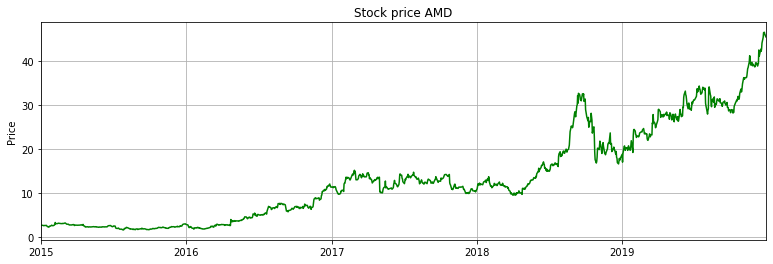

In [5]:
plt.figure(figsize=(13,4))
plt.title('Stock price '+ ticker)
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'], color='g')
plt.show()

In [6]:
y = df['Adj Close'].values.astype(float)

test_size = 21
train_set = y[:-test_size]
test_set = y[-test_size:]

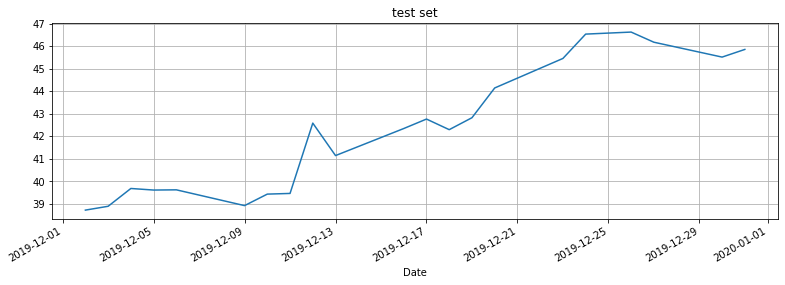

In [7]:
df['Adj Close'].iloc[-test_size:].plot(figsize=(13,4))
plt.title('test set')
plt.grid(True)

# Normalizing data
convert to range [-1, 1]

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [9]:
train_norm.min()

-1.0

In [10]:
train_norm.max()

1.0000000000000002

In [11]:
train_norm.mean()

-0.42980601032287985

In [12]:
train_norm.std()

0.5029290259716455

# Input data and label
window size = 21

[1, 2, 3, ...,21] predict ==> [22]

In [13]:
train_norm = torch.FloatTensor(train_norm).view(-1)

window_size = 21


def input_data(seq,ws): 
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

train_data = input_data(train_norm,window_size)
len(train_data)  

1217

# 2. LSTM network
lstm 2 layers 100 nodes

fully connected 1 l layer

In [14]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=[100, 100], output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(input_size,hidden_size[0])
        
        self.lstm2 = nn.LSTM(hidden_size[0], hidden_size[1])
        
        self.linear = nn.Linear(hidden_size[1], output_size)
        
        self.hidden = (torch.zeros(1,1,self.hidden_size[0]),
                       torch.zeros(1,1,self.hidden_size[0]))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out2.view(len(seq),-1))
        return pred[-1] 
        

In [15]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm1): LSTM(1, 100)
  (lstm2): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

# Training

In [16]:
epochs = 100
losses= []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00449444
Epoch:  2 Loss: 0.02586237
Epoch:  3 Loss: 0.08285921
Epoch:  4 Loss: 0.01256891
Epoch:  5 Loss: 0.08828580
Epoch:  6 Loss: 0.06180437
Epoch:  7 Loss: 0.03906082
Epoch:  8 Loss: 0.00728350
Epoch:  9 Loss: 0.03160472
Epoch: 10 Loss: 0.00006944
Epoch: 11 Loss: 0.00025897
Epoch: 12 Loss: 0.00225397
Epoch: 13 Loss: 0.00143171
Epoch: 14 Loss: 0.00432475
Epoch: 15 Loss: 0.00374514
Epoch: 16 Loss: 0.00290376
Epoch: 17 Loss: 0.00421530
Epoch: 18 Loss: 0.00476614
Epoch: 19 Loss: 0.00494367
Epoch: 20 Loss: 0.00495405
Epoch: 21 Loss: 0.00488597
Epoch: 22 Loss: 0.00479118
Epoch: 23 Loss: 0.00654131
Epoch: 24 Loss: 0.01169388
Epoch: 25 Loss: 0.01246978
Epoch: 26 Loss: 0.00784606
Epoch: 27 Loss: 0.00799260
Epoch: 28 Loss: 0.00762748
Epoch: 29 Loss: 0.00738291
Epoch: 30 Loss: 0.00082166
Epoch: 31 Loss: 0.00031999
Epoch: 32 Loss: 0.00082007
Epoch: 33 Loss: 0.00055681
Epoch: 34 Loss: 0.00001993
Epoch: 35 Loss: 0.00000901
Epoch: 36 Loss: 0.00001777
Epoch: 37 Loss: 0.00022208
E

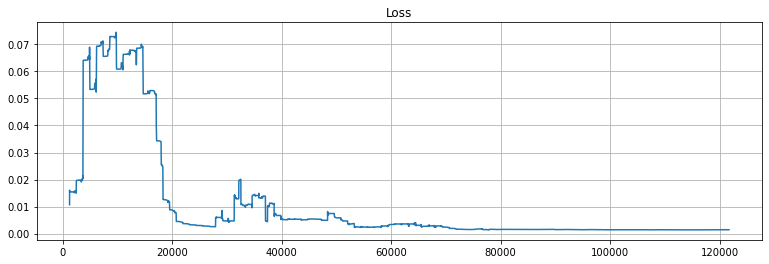

In [18]:
loss = pd.DataFrame(losses, columns=['loss'])
loss['loss'].rolling(1217).mean().plot(figsize=(13,4))
plt.title('Loss')
plt.grid(True)

# Forecast
21 days in future

In [19]:
future = 21

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        preds.append(model(seq).item())

In [20]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])


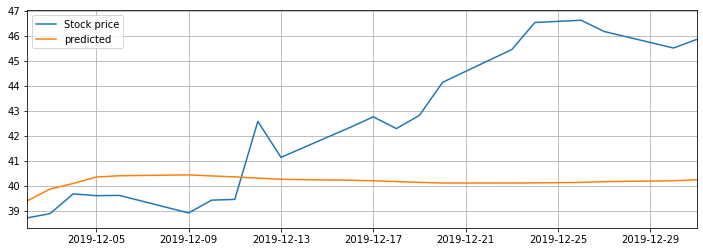

In [23]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-21:], label='Stock price')
plt.plot(df1['pred'], label='predicted')
plt.legend()

# Absolute mean squared error

In [22]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

3.5100564180491514